In [2]:
cd ATML-PA-2/IRM

/kaggle/working/ATML-PA-2/IRM


In [21]:
import importlib
import torch
import utils
import architecture
import train
import types
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights 
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier
import torch

In [14]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
def make_cache(domains, layer_name):
    model = resnet_classifier(len(classes))
    if len(domains)>1:
        caches = []
        for domain in domains:
            ds = OfficeHomeDataset(root_dir, csv_file, [domain], transform)
            caches.append(FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=64))
        return caches
    else:
        ds = OfficeHomeDataset(root_dir, csv_file, domains, transform)
        return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=64)


In [10]:
def analysis(sources, target, config, caches_source=None, cache_target=None):
    
    if caches_source is None:
        caches_source = make_cache(sources, 'layer3')
        

    if cache_target is None:
        cache_target = make_cache(target, 'layer3')

    model = resnet_classifier(num_classes=len(classes))
    truncated_model = _truncate_resnet_from(model, 'layer3')

    def _forward_impl(self, x):
        f4 = self.layer4(x)
        x = torch.flatten(self.avgpool(f4), 1)
        x = self.fc(x)
        return x

    import types
    truncated_model.forward = types.MethodType(_forward_impl, truncated_model)

    train_workflow(truncated_model, caches_source, cache_target, config, device)
    evaluate_ds(cache_target, truncated_model, device, target[0], None)


In [18]:
sources = ["Art", "Real World", "Product"]
target = ["Clipart"]

caches_source = make_cache(sources, 'layer3')
cache_target = make_cache(target, 'layer3')

Precomputing up to layer3: 100%|██████████| 69/69 [00:55<00:00,  1.24it/s]


Training:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1/2


Training:  50%|█████     | 1/2 [00:12<00:12, 12.20s/it]

	ERM loss: 11.806978	Grad penalty: 0.027897	Train Accuracy: 0.1020	Test Accuracy: 0.1054

Epoch 2/2


Training: 100%|██████████| 2/2 [00:23<00:00, 11.65s/it]

	ERM loss: 10.724350	Grad penalty: 0.163862	Train Accuracy: 0.2437	Test Accuracy: 0.1475



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== Evaluation for Clipart Domain ===
Accuracy: 14.75%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.0636    0.9000    0.1188        60
           1     0.1800    0.1607    0.1698        56
           2     0.0000    0.0000    0.0000        64
           3     0.3636    0.0408    0.0734        98
           4     0.1772    0.8788    0.2949        99
           5     0.0867    0.4343    0.1445        99
           6     0.0000    0.0000    0.0000        73
           7     0.4091    0.7826    0.5373        46
           8     0.5000    0.0128    0.0250        78
           9     0.1565    0.4141    0.2271        99
          10     0.1977    0.6970    0.3080        99
          11     0.0000    0.0000    0.0000        40
          12     0.1940    0.2626    0.2232        99
          13     0.0000    0.0000    0.0000        64
          14     0.5455    0.1429    0.2264        42
          15     0.0000    0.0000   

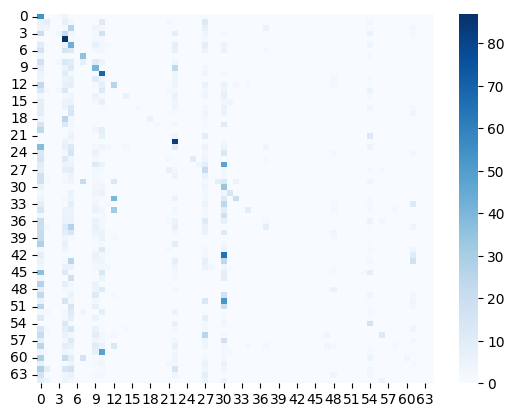

In [22]:
config = {'epochs':2, 
          'lr':1e-3, 
          'batch_size':32, 
          'weight_decay':1e-5, 
          'phi':1.0,
          }
analysis(sources, target, config, caches_source, cache_target)